In [3]:
import numpy as np
import matplotlib.pyplot as plt
from VE_DataGen_Functions import *
from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import *
from deepymod_torch.sparsity import *

torch.set_default_tensor_type('torch.cuda.FloatTensor')

np.random.seed(40)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating data

In [3]:
data = loadmat('Decay_single.mat')

In [4]:
usol = np.real(data['Expression1'])
usol.shape

(7488, 1)

In [5]:
usol= usol.reshape((2496,3))

In [24]:
t_v = np.float32(np.expand_dims(usol[:,0],axis=1))
y_stress = 5*np.float32(np.expand_dims(usol[:,2],axis=1))
y_strain = 5*np.float32(np.expand_dims(usol[:,1],axis=1))

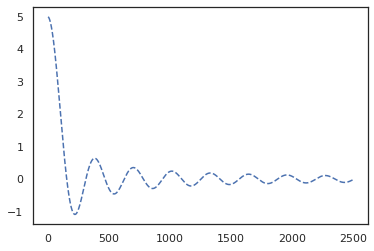

In [25]:
plt.plot(y_stress,'--')

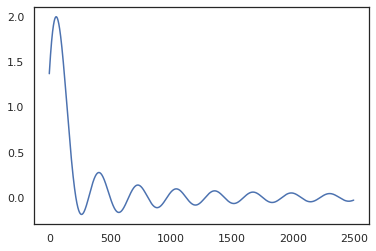

In [26]:
plt.plot(y_strain)

# DeepMoD

In [27]:
np.random.seed(42)  # setting seed for randomisation
noise_level = 0.0

In [29]:
number_of_samples = 2000

idx = np.random.permutation(y_strain.size)
X_train = torch.tensor(t_v[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_strain[idx, :][:number_of_samples], dtype=torch.float32)

In [30]:
X_train.shape

torch.Size([2000, 1])

In [31]:
y_train.shape

torch.Size([2000, 1])

In [48]:
optim_config = {'lambda': 10**-5, 'max_iterations': 50001}

In [33]:
network_config = {'input_dim': 1, 'hidden_dim': 40, 'layers': 6, 'output_dim': y_train.shape[1]}

In [34]:
library_config = {'type': mech_library_group}

In [35]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

1


In [39]:
train_group_mse(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 5.7E-04 5.7E-04
5000 4.9E-05 4.9E-05
10000 2.9E-04 2.9E-04


In [49]:
time_deriv_list, theta, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config) 

Epoch | Total loss | MSE | PI | L1 
0 4.1E-04 2.2E-04 1.2E-04 3.3E-05 3.3E-05
tensor([[ 1.3274],
        [ 1.7946],
        [-0.1608],
        [-0.2444],
        [ 0.3317],
        [ 0.2548],
        [-0.2459]], requires_grad=True)
5000 2.4E-04 1.3E-04 3.8E-05 3.4E-05 3.4E-05
tensor([[1.5087],
        [1.5952],
        [0.3343],
        [0.0058],
        [0.4063],
        [0.3151],
        [0.0261]], requires_grad=True)
10000 8.1E-05 7.9E-06 6.8E-06 3.3E-05 3.3E-05
tensor([[1.6408],
        [1.4568],
        [0.2200],
        [0.0225],
        [0.4398],
        [0.1989],
        [0.0343]], requires_grad=True)
15000 1.1E-04 2.1E-05 2.2E-05 3.2E-05 3.2E-05
tensor([[1.7558],
        [1.3468],
        [0.0441],
        [0.0455],
        [0.4639],
        [0.0629],
        [0.0182]], requires_grad=True)
20000 8.7E-05 1.3E-05 1.1E-05 3.2E-05 3.2E-05
tensor([[1.7663e+00],
        [1.2839e+00],
        [2.9939e-02],
        [4.3050e-04],
        [4.7355e-01],
        [5.9902e-02],
        [2.2

In [50]:
X_all = torch.tensor(t_v, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all).cpu()

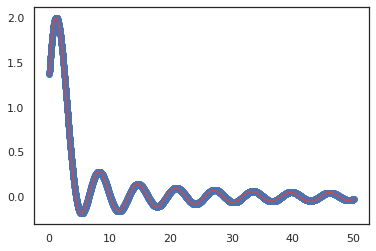

In [51]:
plt.scatter(t_v, y_strain)
plt.plot(t_v,prediction_full.detach().numpy(),'r')

In [52]:
scaled_coeff_vector_list = [scaling(coeff_vector, theta, time_deriv) for coeff_vector, theta , time_deriv in zip(coeff_vector_list, theta, time_deriv_list)]

In [53]:
scaled_coeff_vector_list

[tensor([[1.3278],
         [0.8270],
         [0.1115],
         [0.0721],
         [0.8371],
         [0.2195],
         [0.0511]], grad_fn=<MulBackward0>)]

In [54]:
scaled_coeff_vector_list

[tensor([[1.3278],
         [0.8270],
         [0.1115],
         [0.0721],
         [0.8371],
         [0.2195],
         [0.0511]], grad_fn=<MulBackward0>)]